In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xdeps
import xobjects as xo
from scipy import optimize as opt
import sympy as sp

# Exercise 2

Design machine for protons at 20 GeV with parameters:
- Circumference = 1000 m
- Quadrupole length = 3.0 m
- 8 FODO cells
- dipole length = 5 m, max field = 3 T


In [12]:
def plot_me(myTwiss):
    plt.plot(myTwiss.s,myTwiss.betx,'.-b', label='betx')
    plt.plot(myTwiss.s,myTwiss.bety,'.-r', label='bety')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.alfx,'.-b', label='alfx')
    plt.plot(myTwiss.s,myTwiss.alfy,'.-r', label='alfx')
    plt.xlabel('s [m]')
    plt.ylabel('')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.mux,'.-b', label='mux')
    plt.plot(myTwiss.s,myTwiss.muy,'.-r', label='muy')
    plt.xlabel('s [m]')
    plt.ylabel('2pi')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.dx,'.-b', label='dx')
    plt.plot(myTwiss.s,myTwiss.dy,'.-r', label='dy')
    plt.xlabel('s [m]')
    plt.ylabel('[m]')
    plt.grid()
    plt.legend()

In [18]:
ldipole = 5 #m
lquad = 3 #m
max_field = 3 #T
lring = 1000 #m
p_momentum = 20e9 #GeV
NFODO = 16
lFODO = lring/NFODO #m

Ndipoles = 4*NFODO
gamma = 20e9/938e6 
epsilon_g = 2e-6/gamma
beta_max = (3.14e-3)**2/epsilon_g

def fun(f, L, bmax):
    return (2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)-bmax)**2

f = opt.minimize(fun, x0=100, args=(lFODO,beta_max))['x'][0]
k = 1/f/lquad
beta_max

105.11300639658847

In [19]:
env = xt.Environment()
env.vars({'lFODO': lFODO,
          'lquad': lquad,
         'ldipole': ldipole,
         'lring': lring,
         'p_momentum': p_momentum,
         'k1f': k,
         'k1d': -k,
         'Ndipoles': Ndipoles,
         'NFODO': NFODO,
         'angle.mb': 2*np.pi/Ndipoles,
         'k0.mb': 'angle.mb/ldipole'})

env.new('mb', xt.Bend, length='ldipole', k0='k0.mb', h='k0.mb')
env.new('mq', xt.Quadrupole, length='lquad')
env.new('mq.f','mq', k1='k1f')
env.new('mq.d','mq', k1='k1d')

#at -> the end of the object
fodo = env.new_line(components = [
                    env.place('mq.f', at=env['lquad']/2),
                    env.place('mq.d', at=env['lFODO']/2 + env['lquad']/2),
                    env.place('mb', at=env['lFODO']/6 + env['ldipole']/2),
                    env.place('mb', at=env['lFODO']/3 + env['ldipole']/2),
                    env.place('mb', at=env['lFODO']*4/6 + env['ldipole']/2),
                    env.place('mb', at=env['lFODO']*5/6 + env['ldipole']/2),
                    env.new('marker_end', xt.Marker, at=lFODO)
                    ]
                    )
fodo.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.000000,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0119, k1s=0, length=3, num_mul..."
1,3.000000,Drift,drift_1,True,False,None,False,Drift(length=7.42)
2,10.416667,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0196, k1=0, h=0.0196, mode..."
3,15.416667,Drift,drift_2,True,False,None,False,Drift(length=5.42)
4,20.833333,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0196, k1=0, h=0.0196, mode..."
5,25.833333,Drift,drift_3,True,False,None,False,Drift(length=5.42)
6,31.250000,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0119, k1s=0, length=3, num_mu..."
7,34.250000,Drift,drift_4,True,False,None,False,Drift(length=7.42)
8,41.666667,Bend,mb,True,False,None,False,"Bend(length=5, k0=0.0196, k1=0, h=0.0196, mode..."
9,46.666667,Drift,drift_5,True,False,None,False,Drift(length=5.42)


In [20]:
line = env.new_line(components=[env.place(fodo)]*NFODO)
line.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
context = xo.ContextCpu()
line.build_tracker(_context=context)

optimum = line.match(
    method='4d', # <- passed to twiss
    vary=[
        xt.VaryList(['k1f', 'k1d'], step=1e-4),
    ],
    targets = [
        xt.TargetSet('betx', value=beta_max, at=0, tol=1e-6),
        xt.TargetSet('bety', value=beta_max, at=6, tol=1e-6)
    ])

Matching: model call n. 3               

Warning! Need second attempt on closed orbit search
Matching: model call n. 4               

Could not find point within tolerance.


Warning! Need second attempt on closed orbit search


Could not find point within tolerance.


Matching: model call n. 27               



In [21]:
knobs_after_match = optimum.get_knob_values()
knobs_after_match

{'k1f': 0.0066207482715817225, 'k1d': -0.007968295064840784}

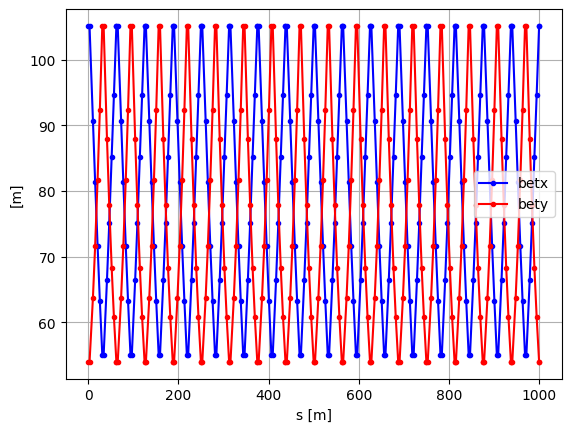

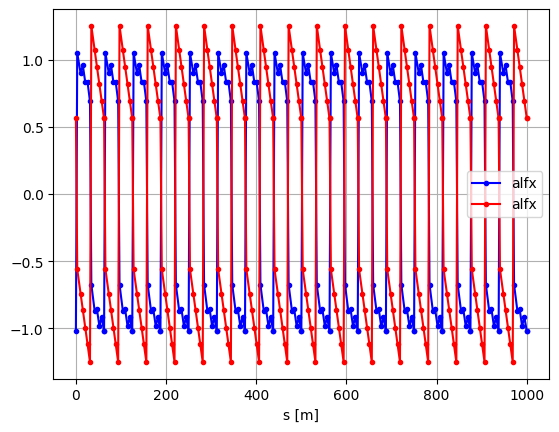

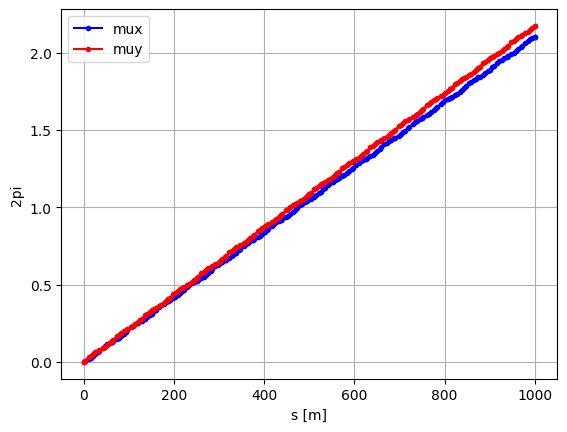

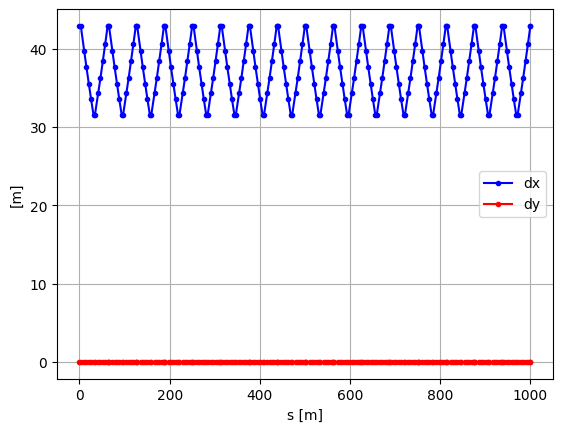

In [22]:
myTwiss= line.twiss(method='4d')
plot_me(myTwiss)

In [40]:
k1s = sp.Symbol('k1s')
k2s = sp.Symbol('k2s')
f = -1/4/np.pi*(knobs_after_match['k1f']*myTwiss.betx[0] + knobs_after_match['k1d']\
            *myTwiss.betx[6] - k1s*myTwiss.betx[4]*myTwiss.dx[4] - k2s*myTwiss.betx[10]*myTwiss.dx[10])
mini = lambda k: sp.lambdify((k1s,k2s), f**2)(k[0],k[1])
opt.minimize(mini, x0 = [-0.01,0.01])

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.0925493047349597e-12
        x: [-1.105e-02  8.648e-03]
      nit: 1
      jac: [-1.021e-04  9.538e-05]
 hess_inv: [[ 6.244e-01 -4.843e-01]
            [-4.843e-01  3.756e-01]]
     nfev: 87
     njev: 25